In [1]:
# ALGORYTM Z "Approximation of piecewise Hölder functions from inexact information"

# PARAMETRY ALGORYTMU:
# h = T/m, gdzie m >= 2r + 1   <--- initial resolution of the mesh
# 0 < w < (r + 1) * h

In [2]:
# Kroki algorytmu:
# 1. aproksymacja punktu osobliwego s_f
#   1a. siatka regularna (o długości h) oraz różnice dzielne użyte są do lokalizacji s_f na przedziale [u_1, v_1] (o długości (r+1) * h)
#   1b. zawęzenie przedziałów z 1a do [u_2, v_2] przy użyciu wielomianów ekstrpolacyjnych p_neg i p_pos
#   1c. wyprodukowanie przedziału [u_3, v_3] zawierającego się (lub równego) [u_2, v_2], w którym różnica |p_pos - p_neg| jest nierosnąca na [u_3, ksi] i niemalejąca na [ksi, v_3], gdzie ksi jest finalną aproksymacją s_f
# 2.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fminbound
from scipy import interpolate
import multiprocessing as mp


In [4]:
# EXAMPLE FUNCTION
f1__a = 0
f1__b = 2 * np.pi + 0.5
f1__r = 3
f1__rho = 10e-4

def f1(x):
    def raw_f(x):
        if 0 <= x < np.pi:
            return np.sin(x - np.pi)
        if np.pi <= x <= 2 * np.pi + 0.5:
            return np.sin(x - np.pi - 0.5)

    if isinstance(x, (list, np.ndarray)):
        return [raw_f(elem) for elem in x]
    elif isinstance(x, (float, np.float64)):
        return raw_f(x)
    
    raise Exception("x has to be list or float")

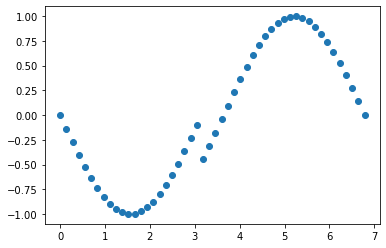

In [5]:
mesh = np.linspace(f1__a, f1__b, 50, dtype='float64')
plt.scatter(mesh, f1(mesh))

In [6]:
# EXAMPLE FUNCTION
f2__a = 0
f2__b = 3 * np.pi
f2__r = 3
f2__rho = 10e-4

def f2(x):
    def raw_f(x):
        if 0 <= x < np.pi:
            return np.sin(x)
        if np.pi <= x <= 3 * np.pi:
            return np.sin(x - np.pi)

    if isinstance(x, (list, np.ndarray)):
        return [raw_f(elem) for elem in x]
    elif isinstance(x, (float, np.float64)):
        return raw_f(x)
    
    raise Exception("x has to be list or float")

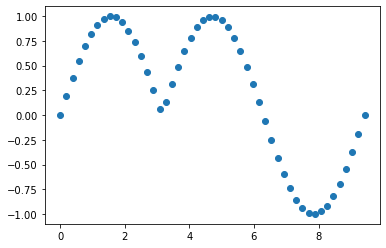

In [7]:
mesh = np.linspace(f2__a, f2__b, 50, dtype='float64')
plt.scatter(mesh, f2(mesh))

In [8]:
def devided_diff(t, y, r, i):
    '''
    t : array of data points t_i, ... , t_{i+r+1}
    y : array of y_j = f(t_j) + e_j
    '''
    
    products = []
    for j in range(i, i+r+1):
        product = 1.0
        for k in range(i, i+r+1):
            if k == j:
                continue
            product *= 1 / (t[k] - t[j])
        products.append(y[j] * product)

    products.sort()
    return math.fsum(products)

In [9]:
# Step 1
def step1(t, y, m, r):
    i_max = np.argmax([devided_diff(t, y, r, i) for i in range(0, m-r)])
    u_1 = t[i_max]
    v_1 = t[i_max + r +1]
    return u_1, v_1, i_max

In [10]:
# Step 2
def step2(f, t, y, r, d, u_1, v_1, i_max, noise=None):
    p_neg = interpolate.interp1d(
        t[i_max - r:i_max + 1],
        y[i_max - r:i_max + 1],
        fill_value="extrapolate"
    )
    p_pos = interpolate.interp1d(
        t[i_max + r + 1: i_max + 2 * r + 1 + 1],
        y[i_max + r + 1: i_max + 2 * r + 1 + 1],
        fill_value="extrapolate"
    )

    u = u_1
    v = v_1
    while v - u > d:
        z = [u + j * (v - u) / (r + 2) for j in range(1, r + 2)]
        dif = np.abs(p_pos(z) - p_neg(z))
        j_max = np.argmax(dif)

        if noise is None:
            f_value = f(z[j_max])
        else:
            f_value = f(z[j_max]) + np.random.uniform(-noise, noise)

        if np.abs(f_value - p_neg(z[j_max])) <= np.abs(f_value - p_pos(z[j_max])):
            u = z[j_max]
        else:
            v = z[j_max]
    
    u_2 = u.item()
    v_2 = v.item()
    return u_2, v_2, p_neg, p_pos, z


In [11]:
# Step 3
def step3(f, t, u_2, v_2, p_neg, p_pos, z, noise=None):
    u = u_2
    v = v_2

    def fun(x):
        return -1 * np.abs(p_neg(x) - p_pos(x)) # "-" beacuse we are looking for maximum, not minimum
        
    while True:
        z_max = fminbound(func=fun, x1=u, x2=v)
        
        if np.isclose(z_max, u) or np.isclose(z_max, v): # => no local maximum
            break


        if noise is None:
            f_value = f(z_max)
        else:
            f_value = f(z_max) + np.random.uniform(-noise, noise)

        if np.abs(f_value - p_neg(z_max)) <= np.abs(f_value - p_pos(z_max)): # NOISE HANDLING???
            u = z_max
        else:
            v = z_max

    u_3 = u
    v_3 = v
    
    ksi = fminbound(
        func=lambda x: np.abs(p_neg(x) - p_pos(x)),
        x1=u_3, x2=v_3)
    
    return u_3, v_3, ksi

In [12]:
# =====ALGORITHM=====

def Alg2015(f, f__a, f__b, r, rho, m, noise=None):
    '''
    f - funkcja, którą aproksymujemy
    r, rho - stałe regularności funkcji
    f__a, f__b - aproksymowany przedzial
    m - początkowa gęstość siatki
    noise - None lub wartosc losowego szumu
    '''
    # Step 0 (initialization of algorithm's constants and function evaluations)
    h = (f__b - f__a) / m
    d = h ** (r + rho)  # d = -1.0 * np.random.uniform(-(r + 1) * h, 0) # multiply by -1 because we need interval (0, (r + 1) * h]
    t = np.linspace(f__a, f__b, m+1, dtype='float64') # czyli mamy m+1 wezlów postaci t[0], ... , t[m]
    
    if noise is not None:
        e = np.random.uniform(-noise, noise, m+1)
        y = [f(t[j]) + e[j] for j in range(0, m+1)]
    else:
        y = np.array(f(t))

    # kroki algorytmu
    u_1, v_1, i_max = step1(t, y, m, r)
    u_2, v_2, p_neg, p_pos, z = step2(f, t, y, r, d, u_1, v_1, i_max, noise=noise)
    u_3, v_3, ksi = step3(f, t, u_2, v_2, p_neg, p_pos, z, noise=noise)

    # finalna funkcja approksymująca podaną funkcję
    polynomial1 = interpolate.interp1d(
                t[:i_max + 1],
                y[:i_max + 1])

    polynomial2 = interpolate.interp1d(
                t[i_max + r + 1:],
                y[i_max + r + 1:])

    def final_approximation(x):
        def raw_f(x):
            if t[0] <= x < u_1:
                return polynomial1(x)
            if u_1 <= x < ksi:
                return p_neg(x)
            if ksi <= x < v_1:
                return p_pos(x)
            if v_1 <= x <= t[m]:
                return polynomial2(x)
            print("WATCH OUT!!!")
            return -1

        if isinstance(x, (list, np.ndarray)):
            return [raw_f(elem) for elem in x]
        return raw_f(x)

    return t, final_approximation

In [13]:
# delta = 10e-4
# m = 100
# t, f_approximation = Alg2015(f1, f1__a, f1__b, f1__r, f1__rho, m, delta)

# plt.scatter(t,f_approximation(t), s=1)
# plt.plot(t, f_approximation(t))

In [13]:
import types
import functools

def copy_func(f):
    g = types.FunctionType(f.__code__, f.__globals__, name=f.__name__,
                           argdefs=f.__defaults__,
                           closure=f.__closure__)
    g = functools.update_wrapper(g, f)
    g.__kwdefaults__ = f.__kwdefaults__
    return g

In [14]:
import scipy.integrate as integrate

def worst_case_error(fun, fun_data, algorithm, alg_data, num, p=2):
    '''
    calculate worst case error with respect to noise for function fun
    '''
    f__a, f__b, r, rho = fun_data
    m, noise = alg_data
    
    norms = []
    errors = [] # Errors of intergation

    fun_copy = copy_func(fun)
    algorithm_copy = copy_func(algorithm)

    for i in range(num):
        f_approximation = algorithm_copy(fun_copy, f__a, f__b, r, rho, m, noise)[1]
        result, error = integrate.quad(lambda x: abs(fun(x) - f_approximation(x))**p, f__a, f__b)
        norm = result**(1/p)
        norms.append(norm)
        errors.append(error) 

    result = np.max(norms)
    print("worst case error for {} alg runs with m={} equals: {}".format(num, m, result))

    return result

In [16]:
log10_m_array = np.linspace(1.5, 4.5, num=20)
m_array = np.array(np.power(10, log10_m_array), dtype='int')
deltas = [None, 10e-12, 10e-8, 10e-4]

In [19]:
dataset = [(f1, (f1__a, f1__b, 2, f1__rho), Alg2015,(m.item(), None), 10, 2) for m in np.nditer(m_array)]

with mp.Pool(processes=3) as pool:
    results = pool.starmap(worst_case_error, dataset)

    print(results)

In [18]:
for m in np.nditer(m_array):
    error = worst_case_error(
        fun=f1,
        fun_data=(f1__a, f1__b, 2, f1__rho),
        algorithm=Alg2015,
        alg_data=(m.item(), None),
        num=10,
        p=2)

C:\Users\tczyz\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


worst case error for 10 alg runs equals: 0.00817848548944266


C:\Users\tczyz\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:18: IntegrationWarning: The integral is probably divergent, or slowly convergent.


worst case error for 10 alg runs equals: 0.006919047249487012
worst case error for 10 alg runs equals: 0.004375743102099608
worst case error for 10 alg runs equals: 0.0018015425713376785
worst case error for 10 alg runs equals: 0.0008338686496046165
worst case error for 10 alg runs equals: 0.0003133181358559252
worst case error for 10 alg runs equals: 0.00010520485847919952
worst case error for 10 alg runs equals: 4.624879160008224e-05
worst case error for 10 alg runs equals: 3.2050394983462604e-05
worst case error for 10 alg runs equals: 1.036549539448302e-05
worst case error for 10 alg runs equals: 5.1039887292823235e-06
worst case error for 10 alg runs equals: 2.5944154593791726e-06
worst case error for 10 alg runs equals: 1.2228442702203624e-06
worst case error for 10 alg runs equals: 5.961296398791342e-07
worst case error for 10 alg runs equals: 3.503632944722126e-07
worst case error for 10 alg runs equals: 1.4872154192832635e-07
worst case error for 10 alg runs equals: 6.09159601

In [ ]:
# errors_for_deltas_f1 = []
# for delta in deltas:
#     errors = []
#     for m in np.nditer(m_array):
#         error = worst_case_error(
#             fun=f1,
#             fun_data=(f1__a, f1__b, 4, f1__rho),
#             algorithm=Alg2015,
#             alg_data=(m, delta),
#             num=1000,
#             p=2)

#         errors.append(error)
#         print("delta: {} ---   m: {} -> error: {:.12f}".format(delta, m, error))
    
#     errors_for_deltas_f1.append(errors)


# errors_for_deltas_f2 = []
# for delta in deltas:
#     errors = []
#     for m in np.nditer(m_array):
#         error = worst_case_error(
#             fun=f2,
#             fun_data=(f2__a, f2__b, 4, f2__rho),
#             algorithm=Alg2015,
#             alg_data=(m, delta),
#             num=1000,
#             p=2)

#         errors.append(error)
#         print("delta: {} ---   m: {} -> error: {:.12f}".format(delta, m, error))
    
#     errors_for_deltas_f2.append(errors)


C:\Users\tczyz\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  from ipykernel import kernelapp as app


delta: None ---   m: 31 -> error: 0.028661483096
delta: None ---   m: 40 -> error: 0.015960630466
delta: None ---   m: 50 -> error: 0.007324217909
delta: None ---   m: 64 -> error: 0.004749823670
delta: None ---   m: 81 -> error: 0.002727793818
delta: None ---   m: 104 -> error: 0.001825614162
delta: None ---   m: 132 -> error: 0.000451441154
delta: None ---   m: 167 -> error: 0.000587294322
delta: None ---   m: 212 -> error: 0.000373526505
delta: None ---   m: 269 -> error: 0.000108999567
delta: None ---   m: 342 -> error: 0.000071662276
delta: None ---   m: 434 -> error: 0.000097957920
delta: None ---   m: 551 -> error: 0.000036732087
delta: None ---   m: 699 -> error: 0.000015379101
delta: None ---   m: 887 -> error: 0.000009648977
delta: None ---   m: 1126 -> error: 0.000007399074
delta: None ---   m: 1429 -> error: 0.000003662907
delta: None ---   m: 1813 -> error: 0.000002307717
delta: None ---   m: 2301 -> error: 0.000001406909
delta: None ---   m: 2920 -> error: 0.000000793193


C:\Users\tczyz\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  from ipykernel import kernelapp as app


delta: 0.001 ---   m: 40 -> error: 0.018478053288
delta: 0.001 ---   m: 50 -> error: 0.009880453774
delta: 0.001 ---   m: 64 -> error: 0.006825335115
delta: 0.001 ---   m: 81 -> error: 0.004547136353
delta: 0.001 ---   m: 104 -> error: 0.003861128317
delta: 0.001 ---   m: 132 -> error: 0.002978247790
delta: 0.001 ---   m: 167 -> error: 0.002298974849
delta: 0.001 ---   m: 212 -> error: 0.002111203998
delta: 0.001 ---   m: 269 -> error: 0.001757342033
delta: 0.001 ---   m: 342 -> error: 0.001624385648
delta: 0.001 ---   m: 434 -> error: 0.001705469077
delta: 0.001 ---   m: 551 -> error: 0.001730162359
delta: 0.001 ---   m: 699 -> error: 0.001571320249
delta: 0.001 ---   m: 887 -> error: 0.001549161299
delta: 0.001 ---   m: 1126 -> error: 0.001494086806
delta: 0.001 ---   m: 1429 -> error: 0.001565439793
delta: 0.001 ---   m: 1813 -> error: 0.001400067718
delta: 0.001 ---   m: 2301 -> error: 0.001480617226
delta: 0.001 ---   m: 2920 -> error: 0.001448039693
delta: 0.001 ---   m: 3706 -> 

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [ ]:
log10errors_for_deltas_f1 = np.log10(errors_for_deltas_f1)
log10errors_for_deltas_f2 = np.log10(errors_for_deltas_f2)

In [ ]:
log10errors_for_deltas_f1[1]

array([-1.54270134, -1.79694996, -2.13523874, -2.32332251, -2.56418846,
       -2.738591  , -3.34539884, -3.23114419, -3.42767856, -3.9625752 ,
       -4.14470937, -4.00896038, -4.43495428, -4.81306884, -5.01551842,
       -5.13082231, -5.43617327, -5.63681623, -5.85173205, -6.10061743,
       -6.23995767, -6.4695536 , -6.72325676, -6.89125236, -7.06961069,
       -7.29482189, -7.50381757, -7.6562689 , -7.99935833, -8.04835562])

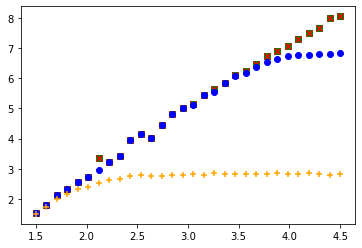

In [ ]:
colors = ['g', 'red', 'b', 'orange']
markers = [',', 'x', 'o', '+', '.', 'v', '^', '<', '>', 's', 'd']

for i in range(4):
    plt.scatter(log10_m_array, -log10errors_for_deltas_f1[i], c=colors[i], marker=markers[i])

plt.show()

In [ ]:
print(log10_m_array)
print(deltas)
print(log10errors_for_deltas_f1)
print(log10errors_for_deltas_f2)

[1.5        1.60344828 1.70689655 1.81034483 1.9137931  2.01724138
 2.12068966 2.22413793 2.32758621 2.43103448 2.53448276 2.63793103
 2.74137931 2.84482759 2.94827586 3.05172414 3.15517241 3.25862069
 3.36206897 3.46551724 3.56896552 3.67241379 3.77586207 3.87931034
 3.98275862 4.0862069  4.18965517 4.29310345 4.39655172 4.5       ]
[None, 1e-11, 1e-07, 0.001]
[[-1.54270134 -1.79694996 -2.13523874 -2.32332251 -2.56418846 -2.738591
  -3.34539885 -3.2311442  -3.42767858 -3.96257523 -4.1447094  -4.00896045
  -4.43495439 -4.81306904 -5.01551872 -5.13082264 -5.43617417 -5.63681744
  -5.85173401 -6.10062122 -6.23996273 -6.46956172 -6.72327183 -6.89127698
  -7.06964534 -7.29487878 -7.5039148  -7.65642066 -7.9996879  -8.04862181]
 [-1.54270134 -1.79694996 -2.13523874 -2.32332251 -2.56418846 -2.738591
  -3.34539884 -3.23114419 -3.42767856 -3.9625752  -4.14470937 -4.00896038
  -4.43495428 -4.81306884 -5.01551842 -5.13082231 -5.43617327 -5.63681623
  -5.85173205 -6.10061743 -6.23995767 -6.469553